# Build Environment

In [ ]:
import numpy as np

class build_environment(object):

  def __init__(self, K, threshold, T, trials):
    self.K = K + 1
    self.mu = None
    self.mu_t = None
    self.threshold = threshold
    self.true_epsilon_arms = []
    self.T = T
    self.trials = trials
    self.G = None
    self.sig = .1
    self.safe_arm = None

    self.baseline = self.K - 1


    
    
    self.best_arm = None

  def find_safe_arms(self, mu):

    safe_set = []
    for k in range(0,self.K-1):
      if mu[k] >= self.threshold:
        safe_set.append(k)
    
    return safe_set

  
  def build_env1(self,):

    self.changepoint_time = [int(self.T/4.0), int((2/4.0)*self.T), int((3/4.0)*self.T), self.T]
    self.G = len(self.changepoint_time)
    print( self.changepoint_time, self.G)

    #self.safe_arm = 2

    self.best_arm = np.zeros(self.G)
    self.mu = np.zeros((self.G, self.K))
    #self.time_change = np.zeros((self.G, self.K))
    self.mu_t = np.zeros((self.T,self.K))
    self.safe_arm_t = np.zeros((self.T,3))
    
    self.baseline = self.K - 1
    self.mu_baseline = 0.35
    
    self.mu[0, :] = [0.2, 0.3, 0.5, 0.6, 0.65, self.mu_baseline]
    self.best_arm[0] = np.argmax(self.mu[0])
    self.mu_t[0:self.changepoint_time[0],:] = self.mu[0,:]
    self.safe_arm_t[0:self.changepoint_time[0],:] = tuple(self.find_safe_arms(self.mu[0, :]))

    self.mu[1, :] = [0.7, 0.65, 0.55, 0.3, 0.25, self.mu_baseline - 0.2] 
    self.best_arm[1] = np.argmax(self.mu[1])
    self.mu_t[self.changepoint_time[0]:self.changepoint_time[1],:] = self.mu[1,:]
    self.safe_arm_t[self.changepoint_time[0]:self.changepoint_time[1],:] = (self.find_safe_arms(self.mu[1, :]))

    self.mu[2, :] = [0.2, 0.75, 0.52, 0.8, 0.3, self.mu_baseline] 
    self.best_arm[2] = np.argmax(self.mu[2])
    self.mu_t[self.changepoint_time[1]:self.changepoint_time[2],:] = self.mu[2,:]
    self.safe_arm_t[self.changepoint_time[1]:self.changepoint_time[2],:] = (self.find_safe_arms(self.mu[2, :]))

    self.mu[3, :] = [0.65, 0.2, 0.55, 0.3, 0.7, self.mu_baseline - 0.2] 
    self.best_arm[3] = np.argmax(self.mu[3])
    self.mu_t[self.changepoint_time[2]:self.changepoint_time[3],:] = self.mu[3,:]
    self.safe_arm_t[self.changepoint_time[2]:self.changepoint_time[3],:] = (self.find_safe_arms(self.mu[3, :]))

  def pull_arm(self, arm, t):

    return self.mu_t[t][arm] + self.sig*np.random.randn()
    
# obj = build_environment(10, 0.1, 1000, 10)
# obj.build_env3()
# print(obj.mu)
# print(obj.mu_t)
# print(obj.pull_arm(1, 1))

# Plot Environment

[2000, 4000, 6000, 8000] 4
[]


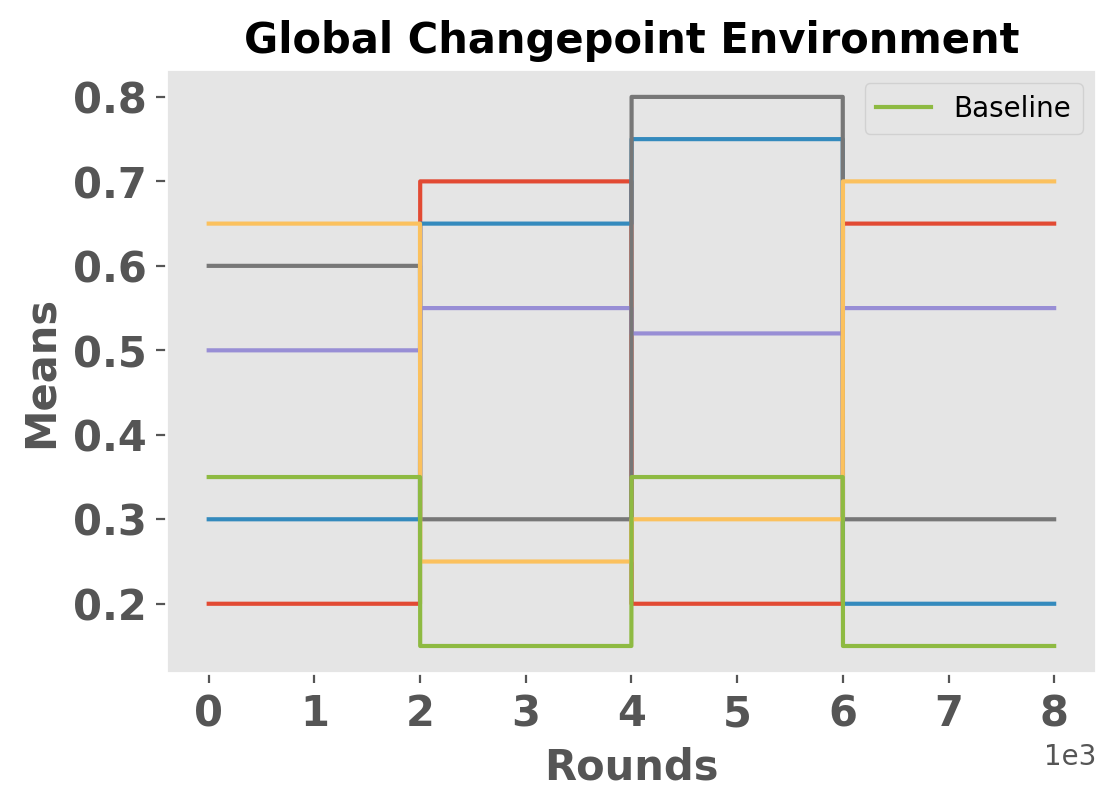

In [ ]:
import matplotlib
import matplotlib.pyplot as plt


env = build_environment(5, 0.4, 8000, 10)
env.build_env1()
print(env.true_epsilon_arms)

plt.style.use('ggplot')
plt.figure(dpi=200)
# plt.plot([i for i in range(0,8000)], [env.threshold for i in range(0,8000)], '--', color='b', label = "Threshold")
#plt.plot([i for i in range(0,8000)], [1.5*env.threshold for i in range(0,8000)], '--', color='b')
#plt.plot(env.mu, 'ro')
plt.plot([i for i in range(0,8000)], env.mu_t[0:8000, 0:env.K-1])
plt.plot([i for i in range(0,8000)], env.mu_t[0:8000, env.K-1], label = "Baseline")


plt.title('Global Changepoint Environment', size = 15, fontweight='bold')
plt.ylabel('Means', size = 15, fontweight='bold')
plt.xlabel('Rounds', size = 15, fontweight='bold')
    
plt.yticks(size = 15, fontweight='bold')
plt.xticks(size = 15, fontweight='bold')

#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

plt.legend()
plt.grid()
plt.show()

# Set Parameters

In [ ]:
T = 8000
trials = 10
env = build_environment(5, 0.4, T, trials)
env.build_env1()

[2000, 4000, 6000, 8000] 4


# Unbalanced MOSS

In [ ]:
import numpy as np

class UMOSS_Sampling(object):

  def __init__(self, env, confidence, type_):
    
    
    self.env = env
    self.confidence = confidence
    
    self.K = env.K
    self.T = env.T
    self.trials = env.trials


    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    self.tol = 0.01
    self.gamma = 0.01
    
    self.budget = 0
    self.budget_error = 0
    self.alpha = 0.7

    self.estimated_G = np.zeros(self.K)
    self.type_ = type_
    
    
    
    self.error = np.zeros((self.trials, self.T))




  def run_algorithm(self, tr):

    self.seed = tr
    np.random.seed(self.seed)
    self.t = 0
    self.ts = np.zeros(self.K)
    self.tp = np.zeros(self.K)

    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))

    #Sample each arm once
    

    for i in range(0,self.K):
      
      arm = i
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]

      self.tp[arm] += 1

      self.t += 1



    sum1 = 0.0
    self.ucb = np.zeros(self.K)
    self.lcb = np.zeros(self.K)
    self.B = np.zeros(self.K)
    while self.t < self.T:
      
      for k in range(self.K):

        if k == self.env.baseline:
          self.B[k] = (self.T*self.K)/(np.sqrt(self.T*self.K) + (self.K/(self.alpha*self.env.mu_t[self.t][self.env.baseline])))
        else:
          self.B[k] = np.sqrt(self.T*self.K) + (self.K/(self.alpha*self.env.mu_t[self.t][self.env.baseline]))
        
        n_k = (self.B[k]*self.B[k])/(self.T*self.T)
        beta_ucb = np.sqrt(4.0*np.log(max(0, (n_k/ (np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) ) ))/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1)) - np.sqrt(1.0/n_k)
        self.ucb[k] = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) + beta_ucb
        self.lcb[k] = max(0.0,np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - beta_ucb)

      arm = np.argmax(self.ucb)

      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]
      self.mu_hat[self.t, :] = [np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]
      
      self.tp[arm] += 1
      #print("t:"+str(self.numplays[self.t]))
      # if self.t > 1.0*self.K:
      #   #print(t)

      # self.budget +=  self.lcb[arm] + self.ucb[np.argmax(self.ucb)] - (1.0-self.alpha)*self.ucb[self.env.baseline] - self.alpha*self.env.threshold
      self.budget +=  self.lcb[arm] + self.ucb[np.argmax(self.ucb)] - (1.0-self.alpha)*self.ucb[self.env.baseline]
      

      error1 = 0
      
      #max(-1.0*self.budget_error,0.0)
      error1 = self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - self.env.mu_t[self.t][arm] + max(self.budget_error, 0.0)
      #print(self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])], self.env.mu_t[self.t][arm])
      sum1 += error1
      self.error[tr][self.t] =  sum1
      #print(self.t,sum1)   
      
      if self.t%100 == 0 and self.t > 2.0*self.K:
        print("t " +str(self.t))
        print("t reward-arm: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ))
        
        print("t numplay: " + str([np.sum(self.numplays[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ), str(np.sum(self.numplays[int(self.ts[i]):self.t,:])))
        print("t mu-hat: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]   ))
        print("T true mu: " + str(self.env.mu_t[self.t]) + " Err: " + str(self.error[tr][self.t]))
        print(np.argmax(self.mu_hat[self.t]), np.argmax(self.env.mu_t[self.t]))
        print()
      
      self.t += 1

  def run_UMOSS_sampling(self, ):

    for tr in range(0,self.trials):
      
      print(tr, end=", ")
      self.run_algorithm(tr)


# T = 8000
# trials = 10
# env = build_environment(5, 0.4, T, trials)
# env.build_env1()
umoss = UMOSS_Sampling(env, 0.10, "global")
umoss.run_UMOSS_sampling()




0, t 100
t reward-arm: [19.14707330515005, 0.3400157208367223, 0.597873798410574, 0.8240893199201458, 0.8367557990149967, 0.2522722120123589]
t numplay: [95.0, 1.0, 1.0, 1.0, 1.0, 1.0] 100.0
t mu-hat: [0.1994486802619797, 0.17000786041836116, 0.298936899205287, 0.4120446599600729, 0.4183778995074984, 0.12613610600617944]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 42.75000000000003
4 4

t 200
t reward-arm: [39.96720301262843, 0.3400157208367223, 0.597873798410574, 0.8240893199201458, 0.8367557990149967, 0.2522722120123589]
t numplay: [195.0, 1.0, 1.0, 1.0, 1.0, 1.0] 200.0
t mu-hat: [0.20391430108483893, 0.17000786041836116, 0.298936899205287, 0.4120446599600729, 0.4183778995074984, 0.12613610600617944]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 87.75000000000031
4 4

t 300
t reward-arm: [59.374880407031796, 0.3400157208367223, 0.597873798410574, 0.8240893199201458, 0.8367557990149967, 0.2522722120123589]
t numplay: [295.0, 1.0, 1.0, 1.0, 1.0, 1.0] 300.0
t mu-hat: [0.2005908121

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in sqrt


t 500
t reward-arm: [97.28127118318352, 0.3400157208367223, 0.597873798410574, 0.8240893199201458, 0.8367557990149967, 0.2522722120123589]
t numplay: [495.0, 1.0, 1.0, 1.0, 1.0, 1.0] 500.0
t mu-hat: [0.19613159512738612, 0.17000786041836116, 0.298936899205287, 0.4120446599600729, 0.4183778995074984, 0.12613610600617944]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 222.74999999999818
4 4

t 600
t reward-arm: [115.25196138428424, 0.3400157208367223, 0.597873798410574, 0.8240893199201458, 0.8367557990149967, 0.2522722120123589]
t numplay: [595.0, 1.0, 1.0, 1.0, 1.0, 1.0] 600.0
t mu-hat: [0.1933757741347051, 0.17000786041836116, 0.298936899205287, 0.4120446599600729, 0.4183778995074984, 0.12613610600617944]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 267.74999999999704
4 4

t 700
t reward-arm: [133.90246508264943, 0.3400157208367223, 0.597873798410574, 0.8240893199201458, 0.8367557990149967, 0.2522722120123589]
t numplay: [695.0, 1.0, 1.0, 1.0, 1.0, 1.0] 700.0
t mu-hat: [0.192388599

KeyboardInterrupt: ignored

# DUCB

In [ ]:
import numpy as np

class DUCB_Sampling(object):

  def __init__(self, env, confidence, type_):
    
    
    self.env = env
    self.confidence = confidence
    
    self.K = env.K
    self.T = env.T
    self.trials = env.trials


    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    self.tol = 0.01
    self.gamma = 0.01
    
    self.budget = 0
    self.budget_error = 0
    self.alpha = 0.7

    self.estimated_G = np.zeros(self.K)
    self.type_ = type_
    
    
    
    self.error = np.zeros((self.trials, self.T))




  def run_algorithm(self, tr):

    self.seed = tr
    np.random.seed(self.seed)
    self.t = 0
    self.ts = np.zeros(self.K)
    self.tp = np.zeros(self.K)

    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    #Sample each arm once
    

    for i in range(0,self.K):
      
      arm = i
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]

      self.tp[arm] += 1

      self.t += 1



    sum1 = 0.0
    self.ucb = np.zeros(self.K)
    self.lcb = np.zeros(self.K)
    self.B = np.zeros(self.K)

    self.gamma = 1 - (1/(4.0*np.sqrt(self.T)))
    while self.t < self.T:
      
      for k in range(self.K):

        
        beta_ucb = 2.0*np.sqrt(2.0*np.log(self.t+1.0)/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))
        #print(beta_ucb)
        self.ucb[k] = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) + beta_ucb
        self.lcb[k] = max(0.0,np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - beta_ucb)

      arm = np.argmax(self.ucb)

      reward = self.gamma*self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = self.gamma*1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]
      self.mu_hat[self.t, :] = [np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]
      
      self.tp[arm] += 1
      

      self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0 - self.alpha)*self.ucb[np.argmin(self.env.safe_arm_t[self.t])]
      

      error1 = 0
      
      #max(-1.0*self.budget_error,0.0)
      error1 = self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - self.env.mu_t[self.t][arm] + max(self.budget_error, 0.0)
      #print(self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])], self.env.mu_t[self.t][arm])
      sum1 += error1
      self.error[tr][self.t] =  sum1
      #print(self.t,sum1)   
      
      if self.t%100 == 0 and self.t > 2.0*self.K:
        print("t " +str(self.t))
        print("t reward-arm: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ))
        
        print("t numplay: " + str([np.sum(self.numplays[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ), str(np.sum(self.numplays[int(self.ts[i]):self.t,:])))
        print("t mu-hat: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]   ))
        print("T true mu: " + str(self.env.mu_t[self.t]) + " Err: " + str(self.error[tr][self.t]))
        print(np.argmax(self.mu_hat[self.t]), np.argmax(self.env.mu_t[self.t]))
        print()
      
      self.t += 1

  def run_DUCB_sampling(self, ):

    for tr in range(0,self.trials):
      
      print(tr, end=", ")
      self.run_algorithm(tr)


# T = 8000
# trials = 10
# env = build_environment(5, 0.4, T, trials)
# env.build_env1()
ducb = DUCB_Sampling(env, 0.10, "global")
ducb.run_DUCB_sampling()




0, t 100
t reward-arm: [2.670095126930818, 4.297895776719011, 7.112485339572588, 12.846838399159639, 15.58452588267022, 5.012080088527932]
t numplay: [11.969254065309377, 13.963663895365627, 15.95807372542188, 20.944098300562505, 22.938508130618754, 13.963663895365627] 99.73726201264377
t mu-hat: [0.20587885112628673, 0.2872221540641598, 0.419415875572604, 0.5854347817440432, 0.6510232716940576, 0.33495005792533306]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 16.95000000000001
4 4

t 200
t reward-arm: [4.958154649779715, 7.525360768063347, 16.527949839493477, 24.911063844176013, 33.86758201178212, 9.414687711921696]
t numplay: [21.94130321559063, 24.932917960675006, 33.907762195928136, 41.88540151615314, 49.86304083637813, 26.927327790731255] 199.4577535154563
t mu-hat: [0.21612349582695953, 0.29018565436696697, 0.4734749178915113, 0.580875145468629, 0.6658583807588522, 0.3371138041730694]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 32.65000000000001
4 4

t 300
t reward-arm: [6

KeyboardInterrupt: ignored

# UCB-CPD

In [ ]:
import numpy as np

class UCB_Sampling(object):

  def __init__(self, env, confidence, type_):
    
    
    self.env = env
    self.confidence = confidence
    
    self.K = env.K
    self.T = env.T
    self.trials = env.trials


    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    self.tol = 0.01
    self.gamma = 0.01
    
    self.budget = 0
    self.budget_error = 0
    self.alpha = 0.7

    self.estimated_G = np.zeros(self.K)
    self.type_ = type_
    
    
    
    self.error = np.zeros((self.trials, self.T))
  

  def detect_changepoint(self, ts, tp):

   

    for k in range(self.K):
      
      #print(tp)
      for t_ in range(int(ts[k])+1,self.t):

        self.confidence = 1.0/self.t
        beta_ts = np.sqrt(0.5*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1))
        beta_tp = np.sqrt(0.5*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[t_:self.t, k]) + 1))

        if (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k])+1) - beta_ts > np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) + beta_tp) \
          or (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1) + beta_ts < np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) - beta_tp): 
            
         

          if self.type_ == "global":
            for k1 in range(self.K):

              self.estimated_G[k1] += 1

              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.mu_hat[int(ts[k1]): self.t, k1] = 0.0
              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.numplays[int(ts[k1]): self.t, k1] = 0
              self.sumreward[int(ts[k1]): self.t, k1] = 0.0
              self.reward_arm[int(ts[k1]): self.t, k1] = 0.0
              self.ts[k1] = self.t

              #print(self.reward_arm[0: self.t, k])
            print("Global Changepoint Detected at time " + str(self.t))
            
            break
          
          else:
            
            self.estimated_G[k] += 1
            self.mu_hat[int(ts[k]): self.t, k] = 0.0
            self.numplays[int(ts[k]): self.t, k] = 0
            self.sumreward[int(ts[k]): self.t, k] = 0.0
            self.reward_arm[int(ts[k]): self.t, k] = 0.0
            self.ts[k] = self.t

            

            print("Arm "+ str(k) +" Changepoint Detected at time " + str(self.t))
            continue



  def run_algorithm(self, tr):

    self.seed = tr
    np.random.seed(self.seed)
    self.t = 0
    self.ts = np.zeros(self.K)
    self.tp = np.zeros(self.K)

    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))

    #Sample each arm once
    

    for i in range(0,self.K):
      
      arm = i
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]

      self.tp[arm] += 1

      self.t += 1



    sum1 = 0.0
    self.ucb = np.zeros(self.K)
    self.lcb = np.zeros(self.K)

    while self.t < self.T:
      
      for k in range(self.K):

        beta_ucb = np.sqrt(1.0*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))
        self.ucb[k] = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) + beta_ucb
        self.lcb[k] = max(0.0,np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - beta_ucb)

      arm = np.argmax(self.ucb)

      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]
      self.mu_hat[self.t, :] = [np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]
      
      self.tp[arm] += 1
      #print("t:"+str(self.numplays[self.t]))
      # if self.t > 1.0*self.K:
      #   #print(t)

      self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0 - self.alpha)*self.ucb[np.argmin(self.env.safe_arm_t[self.t])]
      

      if self.t%20 == 0:
        self.detect_changepoint(self.ts, self.tp)
      
      

      error1 = 0
      
      #max(-1.0*self.budget_error,0.0)
      error1 = self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - self.env.mu_t[self.t][arm] + max(self.budget_error, 0.0)
      #print(self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])], self.env.mu_t[self.t][arm])
      sum1 += error1
      self.error[tr][self.t] =  sum1
      #print(self.t,sum1)   
      
      if self.t%100 == 0 and self.t > 2.0*self.K:
        print("t " +str(self.t))
        print("t reward-arm: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ))
        
        print("t numplay: " + str([np.sum(self.numplays[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ), str(np.sum(self.numplays[int(self.ts[i]):self.t,:])))
        print("t mu-hat: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]   ))
        print("T true mu: " + str(self.env.mu_t[self.t]) + " Err: " + str(self.error[tr][self.t]))
        print(np.argmax(self.mu_hat[self.t]), np.argmax(self.env.mu_t[self.t]))
        print(self.budget, self.budget_error)
        print()
      
      self.t += 1

  def run_UCB_sampling(self, ):

    for tr in range(0,self.trials):
      
      print(tr, end=", ")
      self.run_algorithm(tr)


# T = 8000
# trials = 10
# env = build_environment(5, 0.4, T, trials)
# env.build_env1()
ucb = UCB_Sampling(env, 0.10, "global")
ucb.run_UCB_sampling()




0, t 100
t reward-arm: [1.3268474399887056, 2.6465121526003457, 7.292238350434541, 16.811360030770615, 21.96979064998937, 2.9513315315612765]
t numplay: [7.0, 9.0, 15.0, 27.0, 33.0, 9.0] 100.0
t mu-hat: [0.1658559299985882, 0.26465121526003454, 0.4557648969021588, 0.6004057153846648, 0.6461703132349815, 0.29513315315612765]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 11.600000000000009
4 4
-26.12014957180177 0

t 200
t reward-arm: [2.31738496949273, 4.0651663372403375, 13.383023415274259, 37.866976983399205, 45.81152371626938, 5.824134441147317]
t numplay: [11.0, 14.0, 28.0, 60.0, 70.0, 17.0] 200.0
t mu-hat: [0.19311541412439417, 0.27101108914935584, 0.46148356604394, 0.6207701144819542, 0.6452327283981603, 0.32356302450818425]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 20.90000000000003
4 4
-19.20153943141332 0

t 300
t reward-arm: [2.5617327555615717, 5.1637790600611675, 20.77251768147387, 54.35930861217775, 76.56385709565556, 6.804692052296667]
t numplay: [14.0, 18.0, 42.0,

KeyboardInterrupt: ignored

# GLR-UCB

In [ ]:
import numpy as np
import math

class GLR_UCB_Sampling(object):

  def __init__(self, env, confidence, type_):
    
    
    self.env = env
    self.confidence = confidence
    
    self.K = env.K
    self.T = env.T
    self.trials = env.trials


    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    self.tol = 0.01
    self.gamma = 0.01
    
    self.budget = 0
    self.budget_error = 0
    self.alpha = 0.7

    self.estimated_G = np.zeros(self.K)
    self.type_ = type_
    
    
    
    self.error = np.zeros((self.trials, self.T))
  
  def klGauss(self, x, y, sig2 = 0.1):
        """caution modified"""
        """Kullback-Leibler divergence for Gaussian distributions."""
        return ((x-y)*(x-y))/(2*sig2)

  def klucbGauss(self, x, d, sig2=1., precision=0.):
      """klUCB index computation for Gaussian distributions.
    
      Note that it does not require any search.
      """
      #print 2.0*sig2*d, x
      return x + math.sqrt(2.0*sig2*d)

  def klucb(self, x, d, upperbound, lowerbound=-float('inf'), precision=1e-6):
    
        """The generic klUCB index computation.
    
        Input args.: x, d, div, upperbound, lowerbound=-float('inf'), precision=1e-6,
        where div is the KL divergence to be used.
        """
        l = max(x, lowerbound)
        u = upperbound
        while u-l > precision:
            m = (l+u)/2
            if self.klGauss(x, m) > d:
                u = m
            else:
                l = m
        return (l+u)/2

  def detect_changepoint(self, ts, tp):

   

    for k in range(self.K):
      
      #print(tp)
      kl_list = []
      for t_ in range(int(ts[k])+1,self.t):

        
        emp_mean_ts = np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k])+1)
        emp_mean_tp = np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1)
        emp_mean_tot = np.sum(self.reward_arm[int(ts[k]):self.t, k])/(np.sum(self.numplays[int(ts[k]):self.t, k]) + 1)

        s = np.sum(self.numplays[int(ts[k]):t_, k])+1
        n = (np.sum(self.numplays[t_:self.t, k]) + 1)
        n_s = n - s

        #kl_list.append(s*self.klucb(emp_mean_ts, emp_mean_tot, 1e-4) + n_s*self.klucb(emp_mean_tp, emp_mean_tot, 1e-4))
        kl_list.append(s*self.klGauss(emp_mean_ts, emp_mean_tot) + n_s*self.klGauss(emp_mean_tp, emp_mean_tot))
      
      self.confidence = 1.0/self.t
      self.conf_inf = 1.0*np.log(3.0*math.pow(self.t,3.0/2.0)/self.confidence)
      #self.conf_inf = 8.0*np.log(3.0*self.t)


      if max(kl_list) > self.conf_inf:
        
        #if s*self.klGauss(emp_mean_ts, emp_mean_tot) + n_s*self.klGauss(emp_mean_tp, emp_mean_tot) > self.conf_inf:
          if self.type_ == "global":
            for k1 in range(self.K):

              self.estimated_G[k1] += 1

              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.mu_hat[int(ts[k1]): self.t, k1] = 0.0
              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.numplays[int(ts[k1]): self.t, k1] = 0
              self.sumreward[int(ts[k1]): self.t, k1] = 0.0
              self.reward_arm[int(ts[k1]): self.t, k1] = 0.0
              self.ts[k1] = self.t

              #print(self.reward_arm[0: self.t, k])
            print("Global Changepoint Detected at time " + str(self.t))
            
            break
          
          else:
            
            self.estimated_G[k] += 1
            self.mu_hat[int(ts[k]): self.t, k] = 0.0
            self.numplays[int(ts[k]): self.t, k] = 0
            self.sumreward[int(ts[k]): self.t, k] = 0.0
            self.reward_arm[int(ts[k]): self.t, k] = 0.0
            self.ts[k] = self.t

            

            print("Arm "+ str(k) +" Changepoint Detected at time " + str(self.t))
            continue



  def run_algorithm(self, tr):

    self.seed = tr
    np.random.seed(self.seed)
    self.t = 0
    self.ts = np.zeros(self.K)
    self.tp = np.zeros(self.K)

    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    #Sample each arm once
    

    for i in range(0,self.K):
      
      arm = i
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]

      self.tp[arm] += 1

      self.t += 1



    sum1 = 0.0
    self.ucb = np.zeros(self.K)
    self.lcb = np.zeros(self.K)
    self.gamma = np.sqrt(np.log(self.T)/self.T)

    while self.t < self.T:
      
      for k in range(self.K):

        beta_ucb = np.sqrt(1.0*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))
        self.ucb[k] = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) + beta_ucb
        self.lcb[k] = max(0.0,np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - beta_ucb)

      
      if self.t% (self.K/self.gamma) <= self.K:
        arm = np.random.randint(0, self.K-1)
        #print("fe", arm, self.t% (self.K/self.gamma))
      else:
        arm = np.argmax(self.ucb)

      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]
      self.mu_hat[self.t, :] = [np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]
      
      self.tp[arm] += 1
      #print("t:"+str(self.numplays[self.t]))
      # if self.t > 1.0*self.K:
      #   #print(t)

      self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0 - self.alpha)*self.ucb[np.argmin(self.env.safe_arm_t[self.t])]
      
      if self.t%20 == 0:
        self.detect_changepoint(self.ts, self.tp)
      
      

      error1 = 0
      
      #max(-1.0*self.budget_error,0.0)
      error1 = self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - self.env.mu_t[self.t][arm] + max(self.budget_error, 0.0)
      #print(self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])], self.env.mu_t[self.t][arm])
      sum1 += error1
      self.error[tr][self.t] =  sum1
      #print(self.t,sum1)   
      
      if self.t%100 == 0 and self.t > 2.0*self.K:
        print("t " +str(self.t))
        print("t reward-arm: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ))
        
        print("t numplay: " + str([np.sum(self.numplays[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ), str(np.sum(self.numplays[int(self.ts[i]):self.t,:])))
        print("t mu-hat: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]   ))
        print("T true mu: " + str(self.env.mu_t[self.t]) + " Err: " + str(self.error[tr][self.t]))
        print(np.argmax(self.mu_hat[self.t]), np.argmax(self.env.mu_t[self.t]))
        print(self.budget, self.budget_error)
        print()
      
      self.t += 1

  def run_GLR_UCB_sampling(self, ):

    for tr in range(0,self.trials):
      
      print(tr, end=", ")
      self.run_algorithm(tr)


# T = 8000
# trials = 10
# env = build_environment(5, 0.4, T, trials)
# env.build_env1()
glrucb = GLR_UCB_Sampling(env, 0.10, "global")
glrucb.run_GLR_UCB_sampling()




0, t 100
t reward-arm: [1.6559794307212679, 3.5050850592008693, 11.147188622943112, 14.397734565866132, 18.44224205369738, 3.4812115907461063]
t numplay: [7.0, 10.0, 20.0, 24.0, 29.0, 10.0] 100.0
t mu-hat: [0.20699742884015848, 0.3186440962909881, 0.5308185058544339, 0.5759093826346453, 0.6147414017899127, 0.31647378097691875]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 13.00000000000001
4 4
-30.178892501003208 0

t 200
t reward-arm: [2.284775198646644, 4.609945146412395, 18.32512119446198, 28.792261188373942, 44.200723677700054, 7.665438258579374]
t numplay: [12.0, 15.0, 35.0, 49.0, 69.0, 20.0] 200.0
t mu-hat: [0.17575193835743413, 0.2881215716507747, 0.5090311442906105, 0.5758452237674788, 0.6314389096814294, 0.36502086945616063]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 23.100000000000023
4 4
-29.65140890001535 0

t 300
t reward-arm: [2.5991343301352163, 5.666492291317583, 25.79224911981879, 48.287983697985084, 70.23769575420275, 9.749074313016939]
t numplay: [14.0, 19.0, 

KeyboardInterrupt: ignored

# Conservative-UCB

In [ ]:
import numpy as np

class CUCB_Sampling(object):

  def __init__(self, env, confidence, alpha, type_):
    
    
    self.env = env
    self.confidence = confidence
    
    self.K = env.K
    self.T = env.T
    self.trials = env.trials


    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    self.tol = 0.01
    self.gamma = 0.01
    
    self.budget = 0
    self.budget_error = 0
    self.alpha = 0.7

    self.estimated_G = np.zeros(self.K)
    self.type_ = type_
    
    
    
    self.error = np.zeros((self.trials, self.T))
  

  def detect_changepoint(self, ts, tp):

   

    for k in range(self.K):
      
      #print(tp)
      for t_ in range(int(ts[k])+1,self.t):

        
        beta_ts = np.sqrt(0.5*np.log((self.t+1)/self.confidence)/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1))
        beta_tp = np.sqrt(0.5*np.log((self.t+1)/self.confidence)/(np.sum(self.numplays[t_:self.t, k]) + 1))

        if (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k])+1) - beta_ts > np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) + beta_tp) \
          or (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1) + beta_ts < np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) - beta_tp): 
            
         

          if self.type_ == "global":
            for k1 in range(self.K):

              self.estimated_G[k1] += 1

              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.mu_hat[int(ts[k1]): self.t, k1] = 0.0
              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.numplays[int(ts[k1]): self.t, k1] = 0
              self.sumreward[int(ts[k1]): self.t, k1] = 0.0
              self.reward_arm[int(ts[k1]): self.t, k1] = 0.0
              self.ts[k1] = self.t

              #print(self.reward_arm[0: self.t, k])
            print("Global Changepoint Detected at time " + str(self.t))
            
            return True
          
          else:
            
            self.estimated_G[k] += 1
            self.mu_hat[int(ts[k]): self.t, k] = 0.0
            self.numplays[int(ts[k]): self.t, k] = 0
            self.sumreward[int(ts[k]): self.t, k] = 0.0
            self.reward_arm[int(ts[k]): self.t, k] = 0.0
            self.ts[k] = self.t

            

            print("Arm "+ str(k) +" Changepoint Detected at time " + str(self.t))
            continue



  def run_algorithm(self, tr):

    self.seed = tr
    np.random.seed(self.seed)
    self.t = 0
    self.ts = np.zeros(self.K)
    self.tp = np.zeros(self.K)

    self.budget = 0

    #Sample each arm once
    
    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))

    for i in range(0,self.K):
      
      arm = i
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]

      self.tp[arm] += 1

      self.t += 1



    sum1 = 0.0
    self.ucb = np.zeros(self.K)
    self.lcb = np.zeros(self.K)

    while self.t < self.T:
      
      for k in range(self.K):
        self.confidence = 1.0/self.confidence
        beta_ucb = np.sqrt(1.5*np.log((self.t+1)/self.confidence)/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))
        self.ucb[k] = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) + beta_ucb
        self.lcb[k] = max(0.0,np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - beta_ucb)

      if self.budget >= 0:
        arm = np.argmax(self.ucb)
      else:
        #arm = self.env.safe_arm
        arm = self.env.baseline

      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]
      self.mu_hat[self.t, :] = [np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]
      
      self.tp[arm] += 1
      

      
      self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0-self.alpha)*self.ucb[self.env.baseline] 
      
      
      error1 = 0
      
      
      error1 = self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - self.env.mu_t[self.t][arm] + max(self.budget_error, 0.0)
      #print(self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])], self.env.mu_t[self.t][arm])
      sum1 += error1
      self.error[tr][self.t] =  sum1
      #print(self.t,sum1)   
      
      if self.t%100 == 0 and self.t > 2.0*self.K:
        print("t " +str(self.t))
        print("t reward-arm: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ))
        
        print("t numplay: " + str([np.sum(self.numplays[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ), str(np.sum(self.numplays[int(self.ts[i]):self.t,:])))
        print("t mu-hat: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]   ))
        print("T true mu: " + str(self.env.mu_t[self.t]) + " Err: " + str(self.error[tr][self.t]))
        print(np.argmax(self.mu_hat[self.t]), np.argmax(self.env.mu_t[self.t]))
        print(self.budget, self.budget_error)
        print()
      
      self.t += 1

  def run_CUCB_sampling(self, ):

    for tr in range(0,self.trials):
      
      print(tr, end=", ")
      self.run_algorithm(tr)


# T = 8000
# trials = 10
# env = build_environment(5, 0.4, T, trials)
# env.build_env1()
cucb = CUCB_Sampling(env, 0.10, 0.1, "global")
cucb.run_CUCB_sampling()




0, t 100
t reward-arm: [0.6714140763493254, 0.3400157208367223, 0.597873798410574, 0.8240893199201458, 0.8367557990149967, 32.67793144081308]
t numplay: [2.0, 1.0, 1.0, 1.0, 1.0, 94.0] 100.0
t mu-hat: [0.2238046921164418, 0.17000786041836116, 0.298936899205287, 0.4120446599600729, 0.4183778995074984, 0.3439782256927693]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 28.650000000000045
4 4
-24.98985219185741 0

t 200
t reward-arm: [0.6714140763493254, 0.3400157208367223, 0.597873798410574, 0.8240893199201458, 0.8367557990149967, 68.49806114829146]
t numplay: [2.0, 1.0, 1.0, 1.0, 1.0, 194.0] 200.0
t mu-hat: [0.2238046921164418, 0.17000786041836116, 0.298936899205287, 0.4120446599600729, 0.4183778995074984, 0.3512721084527767]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 58.6499999999998
4 4
-36.51462287849012 0

t 300
t reward-arm: [0.6714140763493254, 0.3400157208367223, 0.597873798410574, 0.8240893199201458, 0.8367557990149967, 102.90573854269482]
t numplay: [2.0, 1.0, 1.0, 1.0, 1.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in sqrt


t 600
t reward-arm: [0.6714140763493254, 0.3400157208367223, 0.597873798410574, 0.8240893199201458, 0.8367557990149967, 203.78281951994728]
t numplay: [2.0, 1.0, 1.0, 1.0, 1.0, 594.0] 600.0
t mu-hat: [0.2238046921164418, 0.17000786041836116, 0.298936899205287, 0.4120446599600729, 0.4183778995074984, 0.34249213364697023]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 178.65000000000106
4 4
-34.708380748796586 0

t 700
t reward-arm: [0.6714140763493254, 0.3400157208367223, 0.597873798410574, 0.8240893199201458, 0.8367557990149967, 237.43332321831244]
t numplay: [2.0, 1.0, 1.0, 1.0, 1.0, 694.0] 700.0
t mu-hat: [0.2238046921164418, 0.17000786041836116, 0.298936899205287, 0.4120446599600729, 0.4183778995074984, 0.3416306808896582]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 208.6500000000022
4 4
-29.370625001737828 0

t 800
t reward-arm: [0.6714140763493254, 0.3400157208367223, 0.597873798410574, 0.8240893199201458, 0.8367557990149967, 271.19733038308436]
t numplay: [2.0, 1.0, 1.0, 1.0

KeyboardInterrupt: ignored

# Adversarial CUCB

In [ ]:
import numpy as np

class Adv_CUCB_Sampling(object):

  def __init__(self, env, confidence, alpha, type_):
    
    
    self.env = env
    self.confidence = confidence
    
    self.K = env.K
    self.T = env.T
    self.trials = env.trials


    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    self.tol = 0.01
    self.gamma = 0.01
    
    self.budget = 0
    self.budget_error = 0
    self.alpha = 0.7

    self.estimated_G = np.zeros(self.K)
    self.type_ = type_
    
    
    
    self.error = np.zeros((self.trials, self.T))
  

  def detect_changepoint(self, ts, tp):

   

    for k in range(self.K):
      
      #print(tp)
      for t_ in range(int(ts[k])+1,self.t):

        
        beta_ts = np.sqrt(0.5*np.log((self.t+1)/self.confidence)/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1))
        beta_tp = np.sqrt(0.5*np.log((self.t+1)/self.confidence)/(np.sum(self.numplays[t_:self.t, k]) + 1))

        # beta_ts = np.sqrt(2.0*np.log(4.0*(1.0/np.log(2))*np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1))
        # beta_tp = np.sqrt(2.0*np.log(4.0*(1.0/np.log(2))*np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[t_:self.t, k]) + 1))

        # beta_ucb = np.sqrt(2.0*np.log(4.0*(1.0/np.log(2))*np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))

        if (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k])+1) - beta_ts > np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) + beta_tp) \
          or (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1) + beta_ts < np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) - beta_tp): 
            
         

          if self.type_ == "global":
            for k1 in range(self.K):

              self.estimated_G[k1] += 1

              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.mu_hat[int(ts[k1]): self.t, k1] = 0.0
              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.numplays[int(ts[k1]): self.t, k1] = 0
              self.sumreward[int(ts[k1]): self.t, k1] = 0.0
              self.reward_arm[int(ts[k1]): self.t, k1] = 0.0
              self.ts[k1] = self.t

              #print(self.reward_arm[0: self.t, k])
            print("Global Changepoint Detected at time " + str(self.t))
            
            return True
          
          else:
            
            self.estimated_G[k] += 1
            self.mu_hat[int(ts[k]): self.t, k] = 0.0
            self.numplays[int(ts[k]): self.t, k] = 0
            self.sumreward[int(ts[k]): self.t, k] = 0.0
            self.reward_arm[int(ts[k]): self.t, k] = 0.0
            self.ts[k] = self.t

            

            print("Arm "+ str(k) +" Changepoint Detected at time " + str(self.t))
            continue



  def run_algorithm(self, tr):

    self.seed = tr
    np.random.seed(self.seed)
    self.t = 0
    self.ts = np.zeros(self.K)
    self.tp = np.zeros(self.K)

    self.budget = 0

    #Sample each arm once
    
    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))

    for i in range(0,self.K):
      
      arm = i
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]

      self.tp[arm] += 1

      self.t += 1


    self.ucb = np.zeros(self.K)
    self.lcb = np.zeros(self.K)

    self.gamma = np.sqrt((self.K*np.log(self.K)*np.log(self.T))/(self.T))
    sum1 = 0.0
    self.prob = np.ones(self.K)
    
    sum_prob = np.sum(self.prob)
    for k in range(0,self.K):
      self.prob[k] = self.prob[k]/sum_prob

    
    self.weights = np.ones(self.K)

    while self.t < self.T:
      
      for k in range(self.K):
        self.confidence = 1.0/self.confidence
        beta_ucb = np.sqrt(1.5*np.log((self.t+1)/self.confidence)/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))
        self.ucb[k] = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) + beta_ucb
        self.lcb[k] = max(0.0,np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - beta_ucb)
        self.prob[k] = (1-self.gamma)*(self.weights[k]/sum(self.weights))+(self.gamma/self.K)


      

      sum_prob = np.sum(self.prob)
      for k in range(0,self.K):
        self.prob[k] = self.prob[k]/sum_prob

      #print(self.prob)
      if self.budget >= 0:
        arm = np.random.choice(self.K, p = self.prob)
      else:
        #arm = self.env.safe_arm
        arm = self.env.baseline

      reward = self.env.pull_arm(arm, self.t)

      xj=[0.0]*self.K

      for k in range(self.K):

        if k == arm:
          xj[k] = reward/self.prob[k]

        self.weights[k]=self.weights[k]*np.exp(self.gamma*xj[k]/self.K)
      
      #print(arm, self.budget)


      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]
      self.mu_hat[self.t, :] = [np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]
      
      self.tp[arm] += 1
      
      self.budget +=  self.lcb[arm] + self.ucb[np.argmax(self.ucb)] - (1.0-self.alpha)*self.ucb[self.env.baseline]
      

      error1 = 0
      
      
      error1 = self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - self.env.mu_t[self.t][arm] + max(self.budget_error, 0.0)
      #print(self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])], self.env.mu_t[self.t][arm])
      sum1 += error1
      self.error[tr][self.t] =  sum1
      #print(self.t,sum1)   
      
      if self.t%100 == 0 and self.t > 2.0*self.K:
        print("t " +str(self.t))
        print("t reward-arm: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ))
        
        print("t numplay: " + str([np.sum(self.numplays[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ), str(np.sum(self.numplays[int(self.ts[i]):self.t,:])))
        print("t mu-hat: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]   ))
        print("T true mu: " + str(self.env.mu_t[self.t]) + " Err: " + str(self.error[tr][self.t]))
        print(np.argmax(self.mu_hat[self.t]), np.argmax(self.env.mu_t[self.t]))
        print(self.budget, self.budget_error)
        print(self.prob)
        print()
      
      self.t += 1

  def run_Adv_CUCB_sampling(self, ):

    for tr in range(0,self.trials):
      
      print(tr, end=", ")
      self.run_algorithm(tr)


# T = 8000
# trials = 10
# env = build_environment(5, 0.4, T, trials)
# env.build_env1()
adv_cucb = Adv_CUCB_Sampling(env, 0.10, 0.1, "global")
adv_cucb.run_Adv_CUCB_sampling()




0, t 100
t reward-arm: [0.37640523459676645, 0.3400157208367223, 1.2244856513963518, 0.8240893199201458, 0.8367557990149967, 33.765289230032636]
t numplay: [1.0, 1.0, 2.0, 1.0, 1.0, 94.0] 100.0
t mu-hat: [0.18820261729838322, 0.17000786041836116, 0.40816188379878393, 0.4120446599600729, 0.4183778995074984, 0.35542409715823825]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 28.350000000000044
4 4
nan 0
[0.09444366 0.09444366 0.09987069 0.09444366 0.09444366 0.52235469]

t 200
t reward-arm: [0.37640523459676645, 0.3400157208367223, 1.2244856513963518, 0.8240893199201458, 0.8367557990149967, 68.29092847416781]
t numplay: [1.0, 1.0, 2.0, 1.0, 1.0, 194.0] 200.0
t mu-hat: [0.18820261729838322, 0.17000786041836116, 0.40816188379878393, 0.4120446599600729, 0.4183778995074984, 0.350209889611117]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 58.3499999999998
4 4
nan 0
[0.05646889 0.05646889 0.05918876 0.05646889 0.05646889 0.71493568]

t 300
t reward-arm: [0.37640523459676645, 0.3400157208367

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in sqrt


t 600
t reward-arm: [0.37640523459676645, 0.3400157208367223, 1.2244856513963518, 0.8240893199201458, 0.8367557990149967, 203.32054075339943]
t numplay: [1.0, 1.0, 2.0, 1.0, 1.0, 594.0] 600.0
t mu-hat: [0.18820261729838322, 0.17000786041836116, 0.40816188379878393, 0.4120446599600729, 0.4183778995074984, 0.34171519454352844]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 178.35000000000105
4 4
nan 0
[0.02083256 0.02083256 0.02101196 0.02083256 0.02083256 0.8956578 ]

t 700
t reward-arm: [0.37640523459676645, 0.3400157208367223, 1.2244856513963518, 0.8240893199201458, 0.8367557990149967, 238.05445900596453]
t numplay: [1.0, 1.0, 2.0, 1.0, 1.0, 694.0] 700.0
t mu-hat: [0.18820261729838322, 0.17000786041836116, 0.40816188379878393, 0.4120446599600729, 0.4183778995074984, 0.34252440144743096]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 208.35000000000218
4 4
nan 0
[0.01956545 0.01956545 0.01965452 0.01956545 0.01956545 0.90208369]

t 800
t reward-arm: [0.37640523459676645, 0.3400157208

KeyboardInterrupt: ignored

# SGR 



In [ ]:
import numpy as np

class SGR_Sampling(object):

  def __init__(self, env, confidence, alpha, type_):
    
    
    self.env = env
    self.confidence = confidence
    
    self.K = env.K
    self.T = env.T
    self.trials = env.trials


    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    self.tol = 0.01
    self.gamma = 0.01
    
    self.budget = 0
    self.budget_error = 0
    self.alpha = 0.7

    self.estimated_G = np.zeros(self.K)
    self.type_ = type_
    
    
    
    self.error = np.zeros((self.trials, self.T))
  

  def detect_changepoint(self, ts, tp):

   

    for k in range(self.K):
      
      #print(tp)
      #print(k)
      for t_ in range(int(ts[k])+1,self.t):

        self.confidence = 1.0/self.t
        # beta_ts = np.sqrt(0.5*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1))
        # beta_tp = np.sqrt(0.5*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[t_:self.t, k]) + 1))

        beta_ts = np.sqrt(0.5*np.log(1.0*(1.0/np.log(2))*np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1))
        beta_tp = np.sqrt(0.5*np.log(1.0*(1.0/np.log(2))*np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[t_:self.t, k]) + 1))

        if (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k])+1) - beta_ts > np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) + beta_tp) \
          or (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1) + beta_ts < np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) - beta_tp): 
            
         

          if self.type_ == "global":
            for k1 in range(self.K):

              self.estimated_G[k1] += 1

              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.mu_hat[int(ts[k1]): self.t, k1] = 0.0
              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.numplays[int(ts[k1]): self.t, k1] = 0
              self.sumreward[int(ts[k1]): self.t, k1] = 0.0
              self.reward_arm[int(ts[k1]): self.t, k1] = 0.0
              self.ts[k1] = self.t
              self.safe_set = set()
              self.budget = 0.0

              #print(self.reward_arm[0: self.t, k])
            print("Global Changepoint Detected at time " + str(self.t))
            
            return True
          
          else:
            
            self.estimated_G[k] += 1
            self.mu_hat[int(ts[k]): self.t, k] = 0.0
            self.numplays[int(ts[k]): self.t, k] = 0
            self.sumreward[int(ts[k]): self.t, k] = 0.0
            self.reward_arm[int(ts[k]): self.t, k] = 0.0
            self.ts[k] = self.t
            self.safe_set = set()
            self.budget = 0.0
            

            print("Arm "+ str(k) +" Changepoint Detected at time " + str(self.t))
            continue

  def safe_set_function(self, ):
    
    self.safe_set = set()
    for k in range(0, self.K-1):

      
      if self.mu_hat[self.t-1][k] >= self.alpha*self.env.threshold:
        
        self.safe_set.add((k, self.mu_hat[self.t-1][k]))
    
    return self.safe_set

  def run_algorithm(self, tr):

    self.seed = tr
    #self.seed = 8
    np.random.seed(self.seed)
    self.t = 0
    self.ts = np.zeros(self.K)
    self.tp = np.zeros(self.K)

    self.budget = 0

    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))

    #Sample each arm once
    

    for i in range(0,self.K):
      
      arm = i
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]

      self.tp[arm] += 1

      self.t += 1



    sum1 = 0.0
    self.ucb = np.zeros(self.K)
    self.lcb = np.zeros(self.K)
    self.B = np.zeros(self.K)
    self.safe_set = set()

    while self.t < self.T:
      
      for k in range(self.K):

        beta_ucb = np.sqrt(2.0*np.log(4.0*(1.0/np.log(2))*np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))
        self.ucb[k] = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) + beta_ucb
        self.lcb[k] = max(0.0,np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - beta_ucb)
        self.B[k] = abs(np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - self.alpha*self.env.threshold)*np.sqrt((np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))

      
      # self.safe_set = self.safe_set_function()

      if self.budget >= 0:
        arm = np.argmax(self.ucb)
      elif self.budget < 0:
        arm = self.env.baseline
      
      
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]
      self.mu_hat[self.t, :] = [np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]
      
      self.tp[arm] += 1
      
      self.budget +=  self.lcb[arm] + self.ucb[np.argmax(self.mu_hat[self.t, :])] - (1.0 - self.alpha)*self.ucb[self.env.baseline] 

      if self.t%20 == 0:
        self.detect_changepoint(self.ts, self.tp)
        
          

      error1 = 0
      
      
      error1 = self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - self.env.mu_t[self.t][arm] + max(self.budget_error, 0.0)
      #print(self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])], self.env.mu_t[self.t][arm])
      sum1 += error1
      self.error[tr][self.t] =  sum1
      #print(self.t,sum1)   
      
      if self.t%100 == 0 and self.t > 2.0*self.K:
        print("t " +str(self.t))
        print("t reward-arm: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ))
        
        print("t numplay: " + str([np.sum(self.numplays[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ), str(np.sum(self.numplays[int(self.ts[i]):self.t,:])))
        print("t mu-hat: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]   ))
        print("T true mu: " + str(self.env.mu_t[self.t]) + " Err: " + str(self.error[tr][self.t]))
        print(np.argmax(self.mu_hat[self.t]), np.argmax(self.env.mu_t[self.t]))
        print(self.budget, self.budget_error)
        print()
      
      self.t += 1

  def run_SGR_sampling(self, ):

    for tr in range(0,self.trials):
      
      print(tr, end=", ")
      self.run_algorithm(tr)


# T = 8000
# trials = 10
# env = build_environment(5, 0.4, T, trials)
# env.build_env1()
sgr = SGR_Sampling(env, 0.10, 0.1, "global")
sgr.run_SGR_sampling()




0, t 100
t reward-arm: [2.330791083888016, 3.0318220610822992, 8.306361574638444, 15.989459646263663, 15.179510254804038, 4.710135534668389]
t numplay: [10.0, 11.0, 17.0, 25.0, 24.0, 13.0] 100.0
t mu-hat: [0.21189009853527419, 0.25265183842352495, 0.461464531924358, 0.6149792171639871, 0.6071804101921615, 0.3364382524763135]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 15.20000000000001
3 4
114.24497178127446 0

t 200
t reward-arm: [4.326172712165748, 5.787220093830003, 15.320779905910602, 31.921596215568684, 36.50727372759356, 8.205167207754634]
t numplay: [18.0, 20.0, 32.0, 51.0, 56.0, 23.0] 200.0
t mu-hat: [0.22769330064030255, 0.27558190923000014, 0.46426605775486673, 0.6138768502993978, 0.6404784864490097, 0.3418819669897764]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 28.050000000000022
4 4
204.99096501872376 0



KeyboardInterrupt: ignored

# SGR-Explore

Global Restart with Explore

In [ ]:
import numpy as np

class SGR_Sampling(object):

  def __init__(self, env, confidence, alpha, type_):
    
    
    self.env = env
    self.confidence = confidence
    
    self.K = env.K
    self.T = env.T
    self.trials = env.trials


    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    self.tol = 0.01
    self.gamma = 0.01
    
    self.budget = 0
    self.budget_error = 0
    self.alpha = 0.7

    self.estimated_G = np.zeros(self.K)
    self.type_ = type_
    
    
    
    self.error = np.zeros((self.trials, self.T))
  

  def detect_changepoint(self, ts, tp):

   

    for k in range(self.K):
      
      #print(tp)
      for t_ in range(int(ts[k])+1,self.t):

        self.confidence = 1.0/self.t
        beta_ts = np.sqrt(0.5*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1))
        beta_tp = np.sqrt(0.5*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[t_:self.t, k]) + 1))

        if (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k])+1) - beta_ts > np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) + beta_tp) \
          or (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1) + beta_ts < np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) - beta_tp): 
            
         

          if self.type_ == "global":
            for k1 in range(self.K):

              self.estimated_G[k1] += 1

              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.mu_hat[int(ts[k1]): self.t, k1] = 0.0
              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.numplays[int(ts[k1]): self.t, k1] = 0
              self.sumreward[int(ts[k1]): self.t, k1] = 0.0
              self.reward_arm[int(ts[k1]): self.t, k1] = 0.0
              self.ts[k1] = self.t
              #self.safe_set = set()
              #self.budget = 0.0

              #print(self.reward_arm[0: self.t, k])
            print("Global Changepoint Detected at time " + str(self.t))
            
            return True
          
          else:
            
            self.estimated_G[k] += 1
            self.mu_hat[int(ts[k]): self.t, k] = 0.0
            self.numplays[int(ts[k]): self.t, k] = 0
            self.sumreward[int(ts[k]): self.t, k] = 0.0
            self.reward_arm[int(ts[k]): self.t, k] = 0.0
            self.ts[k] = self.t

            

            print("Arm "+ str(k) +" Changepoint Detected at time " + str(self.t))
            continue

  def safe_set_function(self, ):
    
    self.safe_set = set()
    for k in range(0, self.K-1):

      
      if self.mu_hat[self.t-1][k] >= self.alpha*self.env.threshold:
        
        self.safe_set.add((k, self.mu_hat[self.t-1][k]))
    
    return self.safe_set

  def run_algorithm(self, tr):

    self.seed = tr
    np.random.seed(self.seed)
    self.t = 0
    self.ts = np.zeros(self.K)
    self.tp = np.zeros(self.K)

    self.budget = 0

    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))

    #Sample each arm once
    

    for i in range(0,self.K):
      
      arm = i
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]

      self.tp[arm] += 1

      self.t += 1



    sum1 = 0.0
    self.ucb = np.zeros(self.K)
    self.lcb = np.zeros(self.K)
    self.B = np.zeros(self.K)
    self.safe_set = set()

    self.gamma = np.sqrt(np.log(self.T)/self.T)
    
    while self.t < self.T:
      
      for k in range(self.K):

        # beta_ucb = np.sqrt(1.0*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))
        beta_ucb = np.sqrt(2.0*np.log(4.0*(1.0/np.log(2))*np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))
        self.ucb[k] = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) + beta_ucb
        self.lcb[k] = max(0.0,np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - beta_ucb)
        self.B[k] = abs(np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - self.alpha*self.env.threshold)*np.sqrt((np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))

      
      self.safe_set = self.safe_set_function()

      if self.t% (self.K/self.gamma) <= self.K:
        arm = np.random.randint(0, self.K-1)
        #print("fe", arm, self.t% (self.K/self.gamma))
      else:

        if self.budget >= 0:
          arm = np.argmax(self.ucb)
        elif self.budget < 0:
          arm = self.env.baseline
      
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]
      self.mu_hat[self.t, :] = [np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]
      
      self.tp[arm] += 1
      
      self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0 - self.alpha)*self.lcb[self.env.baseline]
      
      if self.t%20 == 0:
        self.detect_changepoint(self.ts, self.tp)
        
          

      error1 = 0
      
      
      error1 = self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - self.env.mu_t[self.t][arm] + max(self.budget_error, 0.0)
      #print(self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])], self.env.mu_t[self.t][arm])
      sum1 += error1
      self.error[tr][self.t] =  sum1
      #print(self.t,sum1)   
      
      if self.t%100 == 0 and self.t > 2.0*self.K:
        print("t " +str(self.t))
        print("t reward-arm: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ))
        
        print("t numplay: " + str([np.sum(self.numplays[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ), str(np.sum(self.numplays[int(self.ts[i]):self.t,:])))
        print("t mu-hat: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]   ))
        print("T true mu: " + str(self.env.mu_t[self.t]) + " Err: " + str(self.error[tr][self.t]))
        print(np.argmax(self.mu_hat[self.t]), np.argmax(self.env.mu_t[self.t]))
        print(self.budget, self.budget_error)
        print()
      
      self.t += 1

  def run_SGR_sampling(self, ):

    for tr in range(0,self.trials):
      
      print(tr, end=", ")
      self.run_algorithm(tr)


# T = 8000
# trials = 10
# env = build_environment(5, 0.4, T, trials)
# env.build_env1()
sgr = SGR_Sampling(env, 0.10, 0.1, "global")
sgr.run_SGR_sampling()




[2000, 4000, 6000, 8000] 4
0, t 100
t reward-arm: [2.478315494470621, 3.6811591813083933, 8.53299884949385, 15.376821304165416, 15.136836490926823, 4.923310002809764]
t numplay: [10.0, 12.0, 17.0, 24.0, 24.0, 13.0] 100.0
t mu-hat: [0.2253014085882383, 0.28316609086987643, 0.47405549163854727, 0.6150728521666167, 0.6054734596370729, 0.3516650002006974]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 15.50000000000001
3 4
0.0 0

t 200
t reward-arm: [3.74672630278254, 6.2643194562137925, 15.99297501143312, 29.967168431247124, 37.83534533090399, 7.421730131593808]
t numplay: [17.0, 21.0, 33.0, 49.0, 58.0, 22.0] 200.0
t mu-hat: [0.20815146126569667, 0.2847417934642633, 0.47038161798332706, 0.5993433686249425, 0.6412770395068473, 0.3226839187649482]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 28.00000000000002
4 4
2.2255102101428976 0

t 300
t reward-arm: [4.938616154168306, 8.421582541729972, 23.898242463371965, 45.75402643709907, 59.67166461863536, 11.048497291471673]
t numplay: [23.0,

KeyboardInterrupt: ignored

# SLR

In [ ]:
import numpy as np

class SLR_Sampling(object):

  def __init__(self, env, confidence, alpha, type_):
    
    
    self.env = env
    self.confidence = confidence
    
    self.K = env.K
    self.T = env.T
    self.trials = env.trials


    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))
    
    self.tol = 0.01
    self.gamma = 0.01
    
    self.budget = 0
    self.budget_error = 0
    self.alpha = 0.7

    self.estimated_G = np.zeros(self.K)
    self.type_ = type_
    
    
    
    self.error = np.zeros((self.trials, self.T))
  

  def detect_changepoint(self, ts, tp):

   

    for k in range(self.K):
      
      #print(tp)
      for t_ in range(int(ts[k])+1,self.t):

        
        # beta_ts = np.sqrt(0.5*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1))
        # beta_tp = np.sqrt(0.5*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[t_:self.t, k]) + 1))

        beta_ts = np.sqrt(0.5*np.log(1.0*(1.0/np.log(2))*np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1))
        beta_tp = np.sqrt(0.5*np.log(1.0*(1.0/np.log(2))*np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[t_:self.t, k]) + 1))

        if (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k])+1) - beta_ts > np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) + beta_tp) \
          or (np.sum(self.reward_arm[int(ts[k]):t_, k])/(np.sum(self.numplays[int(ts[k]):t_, k]) + 1) + beta_ts < np.sum(self.reward_arm[t_:self.t, k])/(np.sum(self.numplays[t_:self.t, k]) + 1) - beta_tp): 
            
         

          if self.type_ == "global":
            for k1 in range(self.K):

              self.estimated_G[k1] += 1

              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.mu_hat[int(ts[k1]): self.t, k1] = 0.0
              #print(self.mu_hat[int(ts[k1]): int(tp[k1]), k1])
              self.numplays[int(ts[k1]): self.t, k1] = 0
              self.sumreward[int(ts[k1]): self.t, k1] = 0.0
              self.reward_arm[int(ts[k1]): self.t, k1] = 0.0
              self.ts[k1] = self.t
              self.safe_set = set()
              self.budget = 0.0
              #print(self.reward_arm[0: self.t, k])
            print("Global Changepoint Detected at time " + str(self.t))
            
            return True
          
          else:
            
            self.estimated_G[k] += 1
            self.mu_hat[int(ts[k]): self.t, k] = 0.0
            self.numplays[int(ts[k]): self.t, k] = 0
            self.sumreward[int(ts[k]): self.t, k] = 0.0
            self.reward_arm[int(ts[k]): self.t, k] = 0.0
            self.ts[k] = self.t
            self.safe_set = set()
            self.budget = 0.0

            print("Arm "+ str(k) +" Changepoint Detected at time " + str(self.t))
            continue

  def safe_set_function(self, ):
    
    self.safe_set = set()
    for k in range(0, self.K-1):

      #mu_hat = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1)
      #if self.lcb[k] > self.env.threshold and self.ucb[k] < 1.5*self.env.threshold:
      #if self.lcb[k] > self.env.threshold:
      #if self.mu_hat[self.t-1][k] > self.env.threshold and self.mu_hat[self.t-1][k]  < 1.5*self.env.threshold:
      if self.mu_hat[self.t-1][k] >= self.alpha*self.env.threshold:
        
        self.safe_set.add((k, self.mu_hat[self.t-1][k]))
    
    return self.safe_set

  def run_algorithm(self, tr):

    self.seed = tr
    np.random.seed(self.seed)
    self.t = 0
    self.ts = np.zeros(self.K)
    self.tp = np.zeros(self.K)

    self.budget = 0

    self.mu_hat = np.zeros((self.T, self.K))
    self.sumreward = np.zeros((self.T, self.K))
    self.reward_arm = np.zeros((self.T, self.K))
    self.numplays = np.zeros((self.T, self.K))

    #Sample each arm once
    

    for i in range(0,self.K):
      
      arm = i
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]

      self.tp[arm] += 1

      self.t += 1



    sum1 = 0.0
    self.ucb = np.zeros(self.K)
    self.lcb = np.zeros(self.K)
    self.B = np.zeros(self.K)
    self.safe_set = set()
    self.gamma = np.sqrt(np.log(self.T)/self.T)

    while self.t < self.T:
      
      for k in range(self.K):

        beta_ucb = np.sqrt(1.0*np.log(np.log(self.t+1)/self.confidence)/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))
        self.ucb[k] = np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) + beta_ucb
        self.lcb[k] = max(0.0,np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - beta_ucb)
        self.B[k] = abs(np.sum(self.reward_arm[int(self.ts[k]):self.t, k])/(np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1) - self.alpha*self.env.threshold)*np.sqrt((np.sum(self.numplays[int(self.ts[k]):self.t, k]) + 1))

      
      self.safe_set = self.safe_set_function()

      # if self.t% (self.K/self.gamma) <= self.K:
      #   arm = np.random.randint(0, self.K-1)
      #   #print("fe", arm, self.t% (self.K/self.gamma))
      # else:

      #   if self.budget >= 0 and len(self.safe_set) >= 1:
      #     arm = np.argmax(self.ucb)
      #   elif self.budget >= 0 and len(self.safe_set) == 0:
      #     arm = np.argmin(self.B)
      #   elif self.budget < 0 and len(self.safe_set) >= 1:
      #     #print(len(self.safe_set))
      #     #arm = np.random.choice(list(self.safe_set), 1)
      #     arm = min(self.safe_set, key = lambda x: x[1])[0]
      #   elif self.budget < 0 and len(self.safe_set) == 0:
      #     #arm = np.argmax(self.ucb)

      #     arm = self.env.baseline
      
      if self.budget >= 0:
        if self.t% (self.K/self.gamma) <= self.K:
          arm = np.random.randint(0, self.K-1)
          #print("fe", arm, self.t% (self.K/self.gamma))
        else:
          arm = np.argmax(self.ucb)
      elif self.budget < 0:
        arm = self.env.baseline

      
      reward = self.env.pull_arm(arm, self.t)
      #self.sumreward[self.t][arm] += reward
      self.reward_arm[self.t][arm] = reward
      self.numplays[self.t][arm] = 1
      #self.mu_hat[self.t][arm] = self.sumreward[self.t][arm]/self.numplays[self.t][arm]
      self.mu_hat[self.t, :] = [np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]
      
      self.tp[arm] += 1
      #print("t:"+str(self.numplays[self.t]))
      # if self.t > 1.0*self.K:
      #   #print(t)

      # self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0 - self.alpha)*self.ucb[self.env.safe_arm]
      # self.budget_error += (1.0 - self.alpha)*self.env.mu_t[self.t][self.env.safe_arm] - self.env.mu_t[self.t][arm] - self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])]

      # self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0 - self.alpha)*self.ucb[np.argmin(self.safe_set)]
      # self.budget_error += (1.0 - self.alpha)*self.env.mu_t[self.t][self.env.safe_arm] - self.env.mu_t[self.t][arm] - self.env.mu_t[self.t][np.argmin(self.env.mu_t[self.t])]

      # if len(self.safe_set) > 0:
      #   self.budget +=  self.lcb[arm] + self.lcb[np.argmax(self.ucb)] - (1.0 - self.alpha)*self.ucb[min(self.safe_set, key = lambda x: x[1])[0]]
      self.budget +=  self.lcb[arm] + self.ucb[np.argmax(self.mu_hat[self.t, :])] - (1.0 - self.alpha)*self.ucb[self.env.baseline] - self.alpha*self.env.threshold
      #self.budget_error += self.env.mu_t[self.t][arm] + self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - (1.0 - self.alpha)*self.env.mu_t[self.t][self.env.safe_arm]
      #self.budget_error += (1.0 - self.alpha)*self.env.mu_t[self.t][np.argmin(self.env.safe_arm_t[self.t])] - self.env.mu_t[self.t][arm] - self.env.mu_t[self.t][np.argmin(self.env.mu_t[self.t])]


      if self.t%10 == 0:
        self.detect_changepoint(self.ts, self.tp)
        
      error1 = 0
      
      
      error1 = self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])] - self.env.mu_t[self.t][arm] + max(self.budget_error, 0.0)
      #print(self.env.mu_t[self.t][np.argmax(self.env.mu_t[self.t])], self.env.mu_t[self.t][arm])
      sum1 += error1
      self.error[tr][self.t] =  sum1
      #print(self.t,sum1)   
      
      if self.t%100 == 0 and self.t > 2.0*self.K:
        print("t " +str(self.t))
        print("t reward-arm: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ))
        #print(np.sum(self.tp), [int(self.tp[i]) for i in range(self.K)])
        #print(np.sum(self.numplays[int(np.min(self.ts)):int(np.max(self.tp)),:], axis = 1))
        #print(self.numplays[int(self.ts[2]):int(self.tp[2]),2], np.shape(self.numplays[int(self.ts[2]):int(self.tp[2]),2]))
        #print(self.numplays[int(self.ts[2]):self.t,2], np.sum(self.numplays[int(self.ts[2]):self.t,2]))
        print("t numplay: " + str([np.sum(self.numplays[int(self.ts[i]):self.t,i]) for i in range(self.K)]   ), str(np.sum(self.numplays[int(self.ts[i]):self.t,:])))
        print("t mu-hat: " + str([np.sum(self.reward_arm[int(self.ts[i]):self.t,i])/(np.sum(self.numplays[int(self.ts[i]):self.t,i]) + 1 ) for i in range(self.K)]   ))
        print("T true mu: " + str(self.env.mu_t[self.t]) + " Err: " + str(self.error[tr][self.t]))
        print(np.argmax(self.mu_hat[self.t]), np.argmax(self.env.mu_t[self.t]))
        print(self.budget, self.budget_error, self.safe_set)
        print()
      
      self.t += 1

  def run_SLR_sampling(self, ):

    for tr in range(0,self.trials):
      
      print(tr, end=", ")
      self.run_algorithm(tr)


# T = 8000
# trials = 10
# env = build_environment(5, 0.4, T, trials)
# env.build_env1()
slr = SLR_Sampling(env, 0.10, 0.1, "local")
slr.run_SLR_sampling()




Streaming output truncated to the last 5000 lines.
t mu-hat: [0.20935404775088165, 0.2564725848131447, 0.49272273288774704, 0.6009740965552726, 0.643945635747898, 0.26958986305060273]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 50.5499999999995
4 4
992.2884481341566 0 {(3, 0.6009740965552726), (2, 0.49272273288774704), (4, 0.6439282982030732)}

t 1500
t reward-arm: [3.7683728595158694, 6.068402921255549, 44.701758686386135, 216.83651494334092, 637.13098522908, 6.294602678310746]
t numplay: [17.0, 23.0, 90.0, 360.0, 988.0, 22.0] 1500.0
t mu-hat: [0.20935404775088162, 0.2528501217189812, 0.4912281174328147, 0.6006551660480358, 0.6442173763691406, 0.2736783773178585]
T true mu: [0.2  0.3  0.5  0.6  0.65 0.35] Err: 52.49999999999945
4 4
1068.4385841986016 0 {(3, 0.6006551660480358), (2, 0.4912281174328147), (4, 0.6441199741720236)}

t 1600
t reward-arm: [3.7683728595158694, 6.068402921255549, 45.22341924194714, 225.25421753438258, 692.2393022595277, 6.294602678310746]
t numplay: [17.0,

# File Save

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
file = open('/content/drive/My Drive/Expts/SafeChangepoint/Global_Data5', 'wb')

A = umoss.error
B = ucb.error
C = cucb.error
D = glrucb.error
E = sgr.error
# F = slr.error
F = ducb.error


pickle.dump([A, B, C, D, E, F],file) # dump information to that file

file.close()

# Load Data

In [ ]:
import pickle 
file = open('/content/drive/My Drive/Expts/SafeChangepoint/Global_Data5', 'rb')
data = pickle.load(file)
file.close()


umoss.error = data[0]
ucb.error = data[1]
cucb.error = data[2]
glrucb.error = data[3]
sgr.error = data[4]
# slr.error = data[5]
ducb.error = data[5]

print(data[0])

[[   0.      0.      0.   ... 2197.2  2197.25 2197.3 ]
 [   0.      0.      0.   ... 2197.2  2197.25 2197.3 ]
 [   0.      0.      0.   ... 2197.2  2197.25 2197.3 ]
 ...
 [   0.      0.      0.   ... 2197.2  2197.25 2197.3 ]
 [   0.      0.      0.   ... 2197.2  2197.25 2197.3 ]
 [   0.      0.      0.   ... 2197.2  2197.25 2197.3 ]]


# Regret Plot

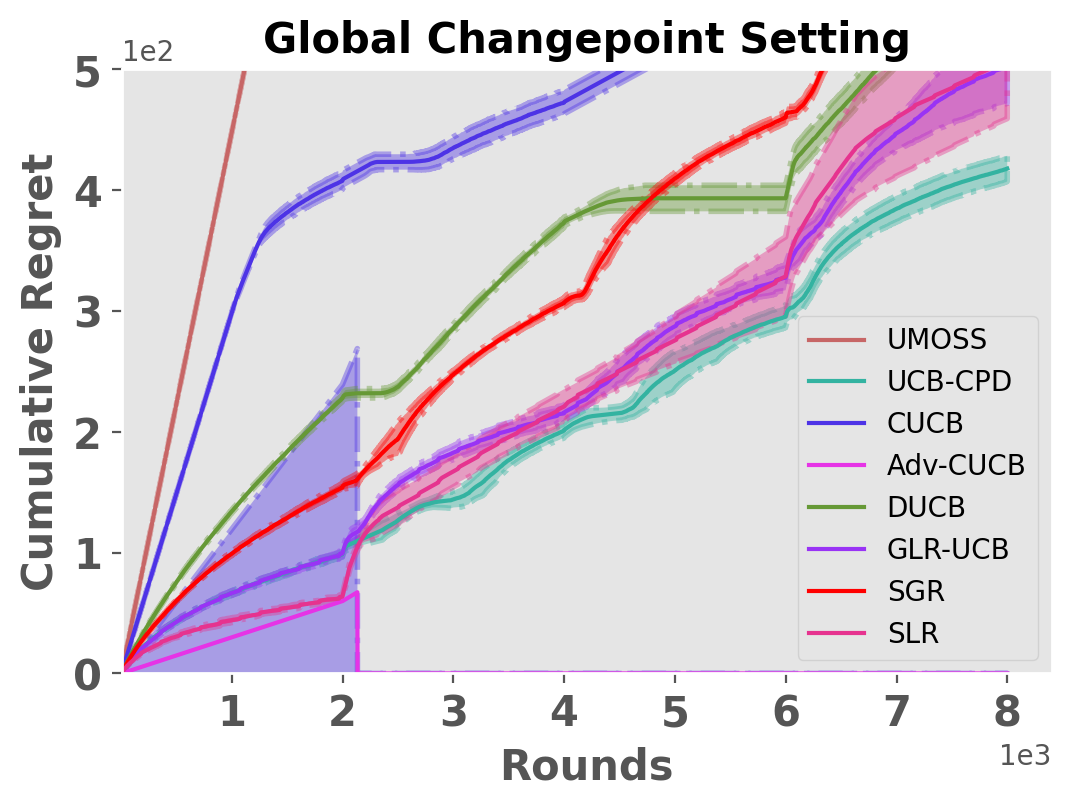

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(dpi=200)
k = 1.0

plt.plot(np.mean(umoss.error, axis = 0), label = "UMOSS", color = (0.78,0.4,0.4))
plt.fill_between(range(env.T), np.average(umoss.error, axis=0) + k*np.std(umoss.error, axis=0), np.average(umoss.error, axis=0) - k*np.std(umoss.error, axis=0), alpha=0.4, edgecolor=(0.78,0.4,0.4), facecolor=(0.78,0.4,0.4), linewidth=2, linestyle='dashdot', antialiased=True)


plt.plot(np.mean(ucb.error, axis = 0), label = "UCB-CPD", color = (0.2,0.7,0.63))
plt.fill_between(range(env.T), np.average(ucb.error, axis=0) + k*np.std(ucb.error, axis=0), np.average(ucb.error, axis=0) - k*np.std(ucb.error, axis=0), alpha=0.4, edgecolor=(0.2,0.7,0.63), facecolor=(0.2,0.7,0.63), linewidth=2, linestyle='dashdot', antialiased=True)

plt.plot(np.mean(cucb.error, axis = 0), label = "CUCB", color = (0.3,0.2,0.9))
plt.fill_between(range(env.T), np.average(cucb.error, axis=0) + k*np.std(cucb.error, axis=0), np.average(cucb.error, axis=0) - k*np.std(cucb.error, axis=0), alpha=0.4, edgecolor=(0.3,0.2,0.9), facecolor=(0.3,0.2,0.9), linewidth=2, linestyle='dashdot', antialiased=True)

plt.plot(np.mean(adv_cucb.error, axis = 0), label = "Adv-CUCB", color = (0.9,0.2,0.9))
plt.fill_between(range(env.T), np.average(adv_cucb.error, axis=0) + k*np.std(adv_cucb.error, axis=0), np.average(adv_cucb.error, axis=0) - k*np.std(adv_cucb.error, axis=0), alpha=0.4, edgecolor=(0.3,0.2,0.9), facecolor=(0.3,0.2,0.9), linewidth=2, linestyle='dashdot', antialiased=True)


plt.plot(np.mean(ducb.error, axis = 0), label = "DUCB", color = (0.4,0.6,0.21))
plt.fill_between(range(env.T), np.average(ducb.error, axis=0) + k*np.std(ducb.error, axis=0), np.average(ducb.error, axis=0) - k*np.std(ducb.error, axis=0), alpha=0.4, edgecolor=(0.4,0.6,0.21), facecolor=(0.4,0.6,0.21), linewidth=2, linestyle='dashdot', antialiased=True)

plt.plot(np.mean(glrucb.error, axis = 0), label = "GLR-UCB", color = (0.6,0.2,0.96))
plt.fill_between(range(env.T), np.average(glrucb.error, axis=0) + k*np.std(glrucb.error, axis=0), np.average(glrucb.error, axis=0) - k*np.std(glrucb.error, axis=0), alpha=0.4, edgecolor=(0.6,0.2,0.96), facecolor=(0.6,0.2,0.96), linewidth=2, linestyle='dashdot', antialiased=True)


plt.plot(np.mean(sgr.error, axis = 0), label = "SGR", color = "r")
plt.fill_between(range(env.T), np.average(sgr.error, axis=0) + k*np.std(sgr.error, axis=0), np.average(sgr.error, axis=0) - k*np.std(sgr.error, axis=0), alpha=0.4, edgecolor="r", facecolor="r", linewidth=2, linestyle='dashdot', antialiased=True)

plt.plot(np.mean(slr.error, axis = 0), label = "SLR", color = (0.9,0.2,0.56))
plt.fill_between(range(env.T), np.average(slr.error, axis=0) + k*np.std(slr.error, axis=0), np.average(slr.error, axis=0) - k*np.std(slr.error, axis=0), alpha=0.4, edgecolor=(0.9,0.2,0.56), facecolor=(0.9,0.2,0.56), linewidth=2, linestyle='dashdot', antialiased=True)


plt.xlim(env.K)


plt.title('Global Changepoint Setting', size = 15, fontweight='bold')
plt.ylabel('Cumulative Regret', size = 15, fontweight='bold')
plt.xlabel('Rounds', size = 15, fontweight='bold')
    
plt.yticks(size = 15, fontweight='bold')
plt.xticks(size = 15, fontweight='bold')

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

plt.grid()
plt.legend()
plt.ylim(0,500)


plt.show()
